# Credit Scoring Data Case

In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import TargetEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import shap
from imblearn.over_sampling import SMOTE

In [2]:
file_path = '/Users/Bora/Desktop/CaseStudyData.xlsx'
   
df = pd.read_excel(file_path, sheet_name=0)               # Data
variable_names = pd.read_excel(file_path, sheet_name=1)   # Variable Description

df = df.drop(columns=df.columns[0])

new_column_names = variable_names['Description'].tolist()
df.columns = new_column_names
df.rename(columns={'Good_Bad_Flag': 'Target'}, inplace=True)

In [3]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_values, missing_percentage

(Target                                             0
 CC Num of application_L1M                          0
 Worst Account Status All Credits                   0
 Any Legal Action YN                                0
 Existing Credit Card Previous Limit             8471
 LO Num of application_L6M                          0
 TS Last Legal Action                           29034
 TS Oldest Open Credit Card                         0
 CC TS First Open Active Credit Card                0
 Last Credit Decision                            9048
 Total Assets_3                                    15
 Any Legal Action no date YN                    28346
 TS Last Closed good account                     4032
 CC Num of application_L6M                          0
 Home Phone YN                                   2052
 Employers Address YN                               0
 AMC_Transfer_Outstanding                       16235
 Existing Customer Limit                         8226
 CC Total Payment of all Cre

### Train-Test Split

In [4]:
X = df.drop(columns=['Target'])
y = df['Target']

# Add a flag to indicate if the data point is from the train or test set
X['TrainFlag'] = True
y_train_flag = y.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set TrainFlag to False for test set
X_test['TrainFlag'] = False
y_test_flag = y_test.copy()

In [5]:
# Concatenate the train and test sets
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

In [6]:
categorical_cols = X_combined.select_dtypes(include=['object']).columns.tolist()

category_counts = X_combined[categorical_cols].nunique() # how many categories each categorical variable has

# 2 groups: <5 categories (one-hot) and >=5 categories (target encoding)
one_hot_cols = category_counts[category_counts < 5].index.tolist()
target_encode_cols = category_counts[category_counts >= 5].index.tolist()

### One-Hot Encoding

In [7]:
X_combined_onehot = pd.get_dummies(X_combined[one_hot_cols], drop_first=True)

X_combined = X_combined.drop(columns=one_hot_cols)

X_combined = pd.concat([X_combined, X_combined_onehot], axis=1)

### Target Encoding

In [8]:
target_encoder = TargetEncoder(cols=target_encode_cols, smoothing=0.3, min_samples_leaf=10)
X_combined[target_encode_cols] = target_encoder.fit_transform(X_combined[target_encode_cols], y_combined)

In [9]:
# Consolidate small categories into a single "Other" category if they appear in less than 5% of the cases
for col in target_encode_cols:
    if 5 <= X_combined[col].nunique() <= 20:
        freq_table = X_combined[col].value_counts(normalize=True)
        to_replace = freq_table[freq_table < 0.05].index  # Combine categories with less than 5% frequency
        X_combined[col] = X_combined[col].replace(to_replace, 'Other')

In [10]:
# Impute missing values in the combined dataset
for column in X_combined.columns: 
    if X_combined[column].dtype == 'object':  # Categorical variables
        X_combined[column].fillna(X_combined[column].mode()[0], inplace=True)
    else:  # Numeric variables
        X_combined[column].fillna(X_combined[column].median(), inplace=True)

In [11]:
# Separate the encoded data back into train and test sets
X_train_processed = X_combined[X_combined['TrainFlag'] == True].drop(columns=['TrainFlag'])
X_test_processed = X_combined[X_combined['TrainFlag'] == False].drop(columns=['TrainFlag'])

In [12]:
# Check if any columns are still categorical after the 'Other' consolidation
remaining_categorical_cols = X_train_processed.select_dtypes(include=['object']).columns

# categorical columns remain, label encoding to 'Other'

label_encoders = {}
for col in remaining_categorical_cols:
    le = LabelEncoder()
    X_train_processed[col] = le.fit_transform(X_train_processed[col].astype(str))
    X_test_processed[col] = le.transform(X_test_processed[col].astype(str))
    label_encoders[col] = le

# Correlation matrix calc
corr_matrix = X_train_processed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop columns with high correlation
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
X_train_processed = X_train_processed.drop(columns=to_drop)
X_test_processed = X_test_processed.drop(columns=to_drop)

print(f"Columns dropped due to high correlation: {to_drop}")

Columns dropped due to high correlation: ['CC TS First Open Active Credit Card', 'Monthly Family Income', 'Declared Monthly Net Income', 'Total Assets_1', 'MO Number of months in 3 or more delay_L6M']


### Standartization

In [13]:
scaler = StandardScaler()

numeric_cols = X_train_processed.select_dtypes(include=['float64', 'int64']).columns

X_train_scaled = X_train_processed.copy()
X_test_scaled = X_test_processed.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_processed[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test_processed[numeric_cols])

### Correlation Matrix

In [14]:
corr_matrix = X_train_processed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

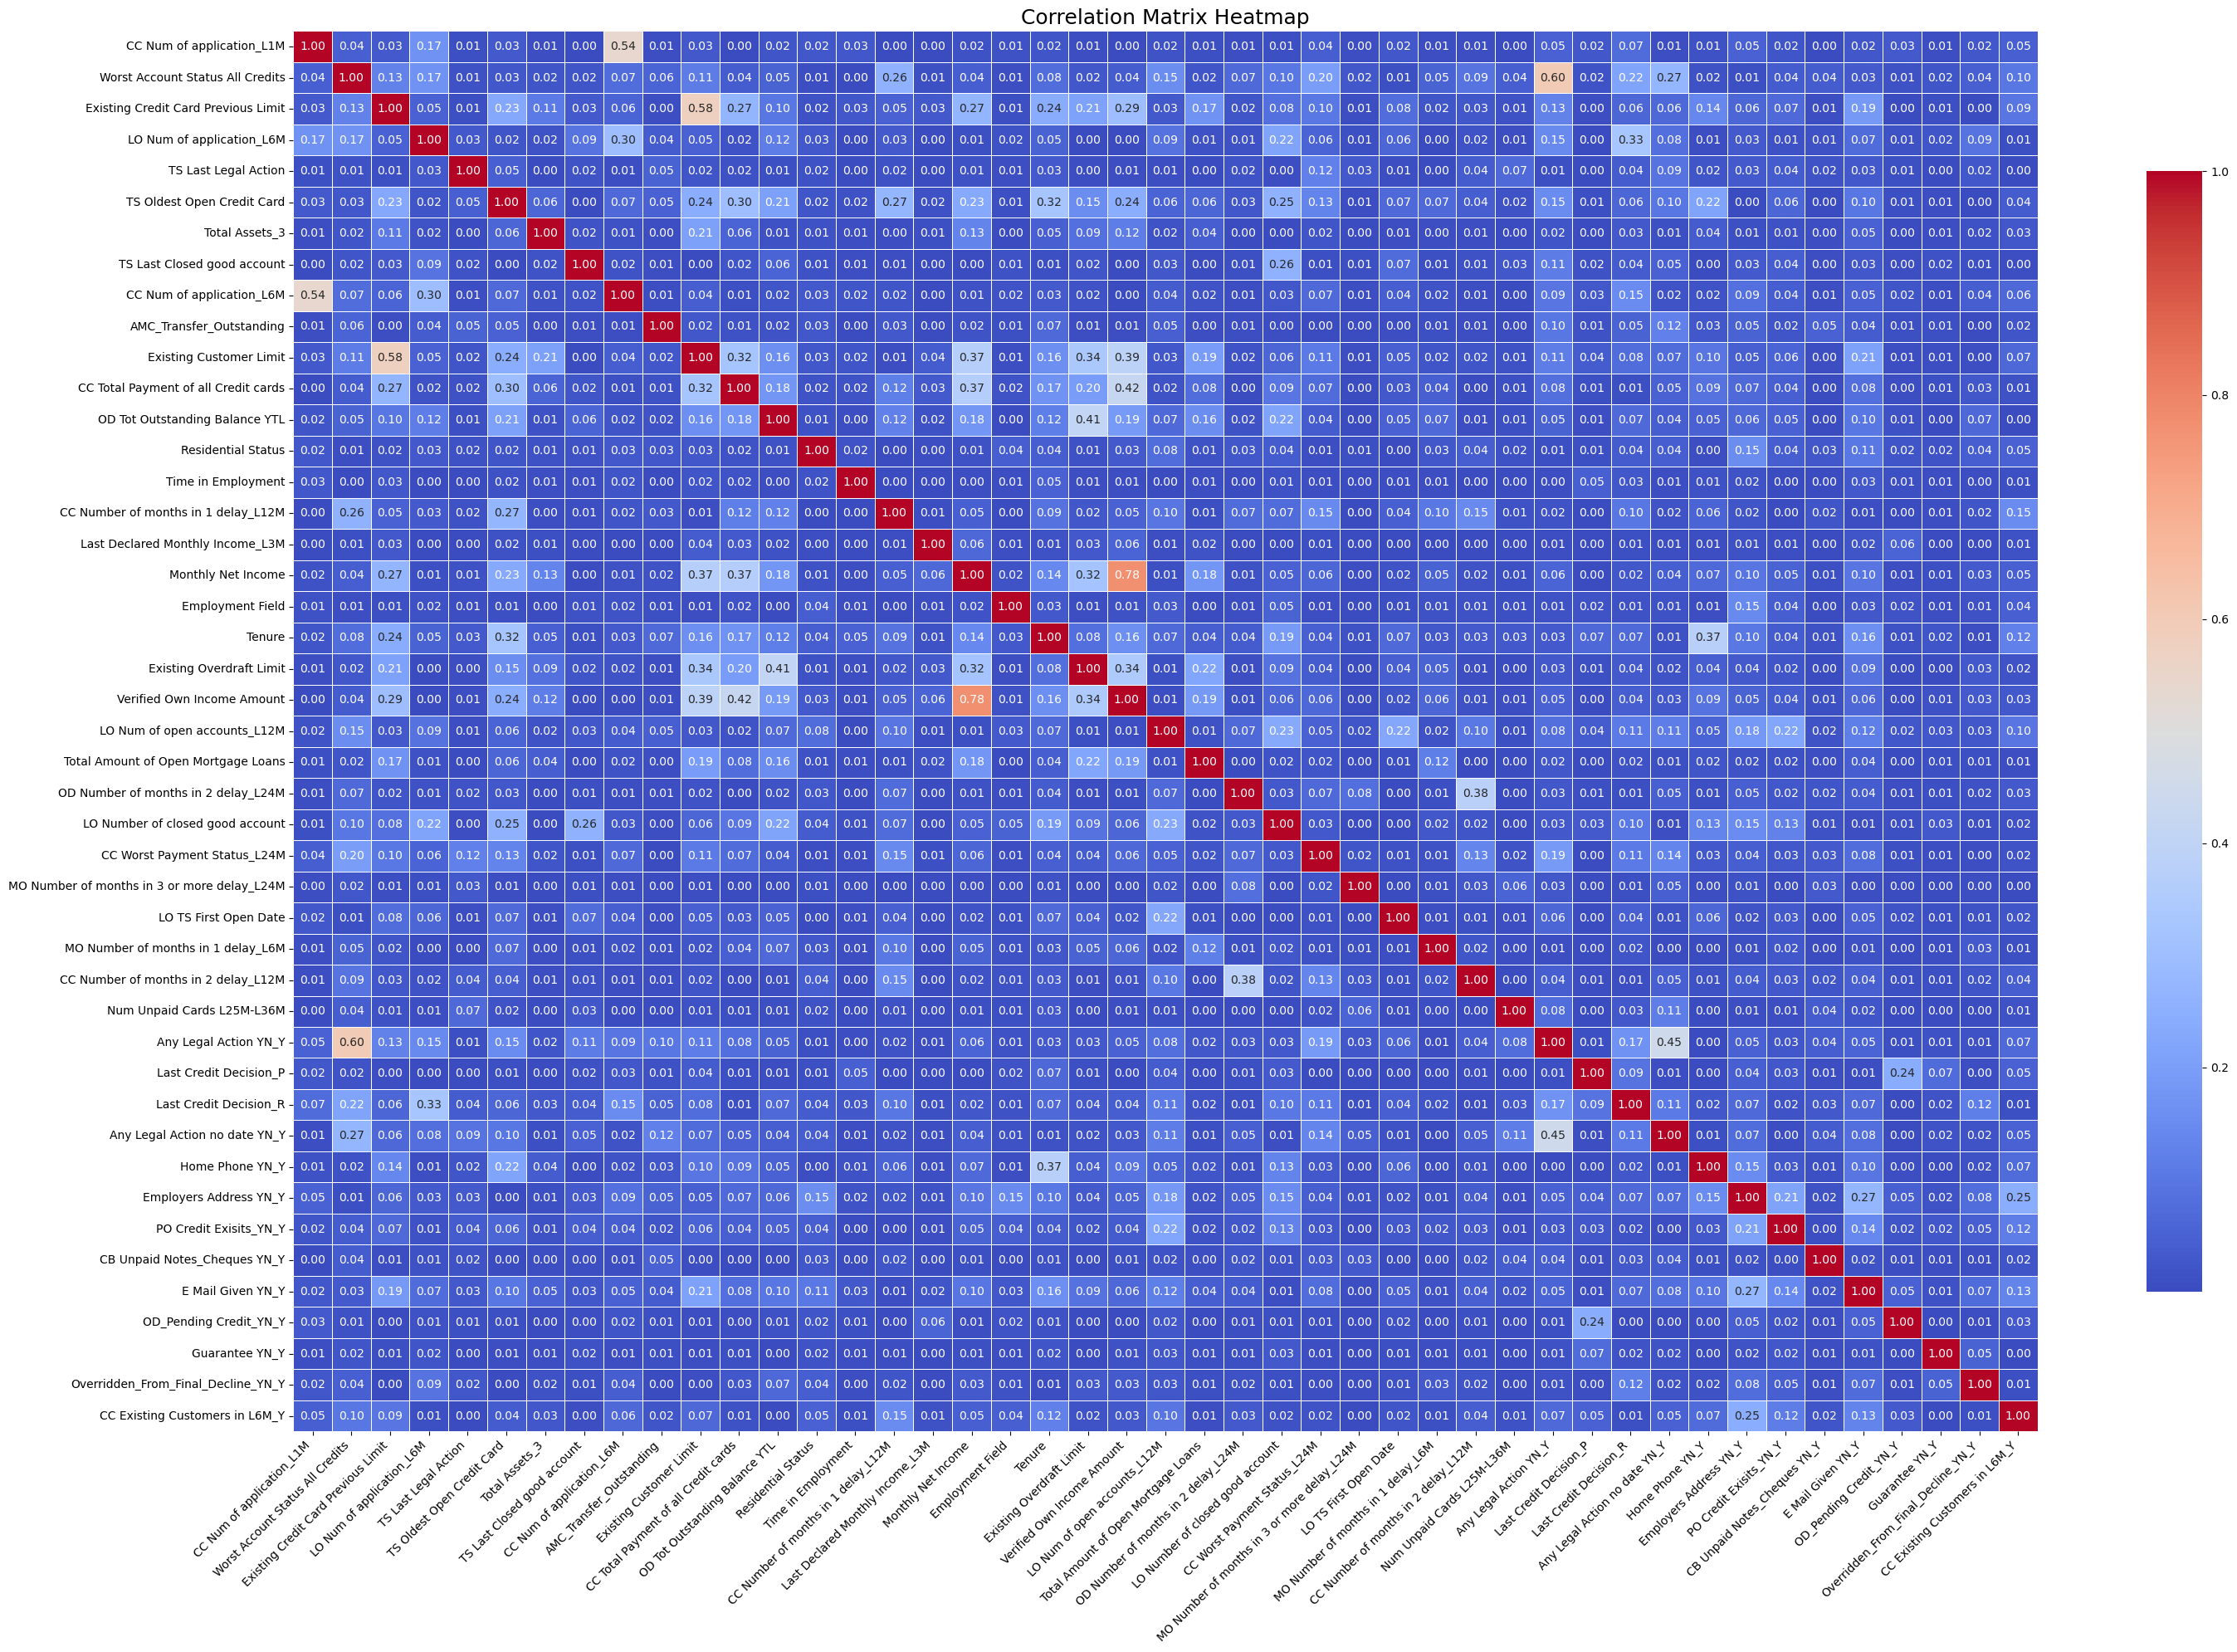

In [15]:
plt.figure(figsize=(30, 20))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})

plt.title("Correlation Matrix Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Random Forest Feature Importance

In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 5-fold cross-val with both train and test 
cv_results = cross_validate(model, X_train_processed, y_train, cv=5, scoring='roc_auc', return_train_score=True)

print(f"Train Scores: {cv_results['train_score']}")
print(f"Validation Scores: {cv_results['test_score']}")

# Fit the model on the entire training set
model.fit(X_train_processed, y_train)
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n", feature_importance_df)

Train Scores: [1. 1. 1. 1. 1.]
Validation Scores: [0.7513926  0.71352891 0.71614058 0.74437569 0.7188156 ]
Feature Importance:
                                         Feature  Importance
17                           Monthly Net Income    0.060990
19                                       Tenure    0.058015
5                    TS Oldest Open Credit Card    0.057764
11         CC Total Payment of all Credit cards    0.054187
3                     LO Num of application_L6M    0.051128
7                   TS Last Closed good account    0.050125
14                           Time in Employment    0.048862
21                   Verified Own Income Amount    0.048647
18                             Employment Field    0.046488
16             Last Declared Monthly Income_L3M    0.042471
12               OD Tot Outstanding Balance YTL    0.042119
25             LO Number of closed good account    0.035864
6                                Total Assets_3    0.033370
15          CC Number of months 

### Lasso

In [17]:
log_reg_lasso = LogisticRegression(class_weight='balanced',penalty='l1', solver='liblinear', random_state=42)  #‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories.
log_reg_lasso.fit(X_train_processed, y_train)

coefficients = log_reg_lasso.coef_[0]

# Sıfır olan katsayılar 
zero_features = X_train_processed.columns[np.where(coefficients == 0)]
print("\nÖnemsiz olan ve modelden çıkarılan özellikler:")
print(zero_features.tolist())


Önemsiz olan ve modelden çıkarılan özellikler:
['CB Unpaid Notes_Cheques YN_Y']


In [18]:
def evaluate_model_performance(y_test, y_pred, y_pred_proba, model_name="Model"):
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    print(f"{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")

    print("\nClassification Report:")
    print(class_report)

In [19]:
def plot_model_performance(y_test, y_pred_proba, model_name="Model"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    plt.figure(figsize=(18, 5))

    # ROC Curve plot
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")

    # Precision-Recall Curve plot
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')

    # Calibration Curve plot
    plt.subplot(1, 3, 3)
    plt.plot(prob_pred, prob_true, marker='o', color='b', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve: {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Logistic Regression

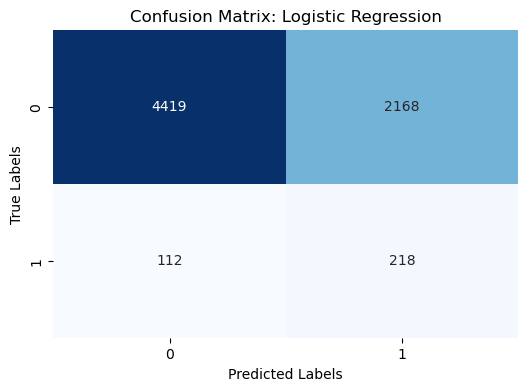

Logistic Regression Model Performance:
Accuracy: 0.67
ROC-AUC: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.79      6587
           1       0.09      0.66      0.16       330

    accuracy                           0.67      6917
   macro avg       0.53      0.67      0.48      6917
weighted avg       0.93      0.67      0.76      6917



In [20]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

evaluate_model_performance(y_test, y_pred_lr, y_pred_proba_lr, model_name="Logistic Regression")

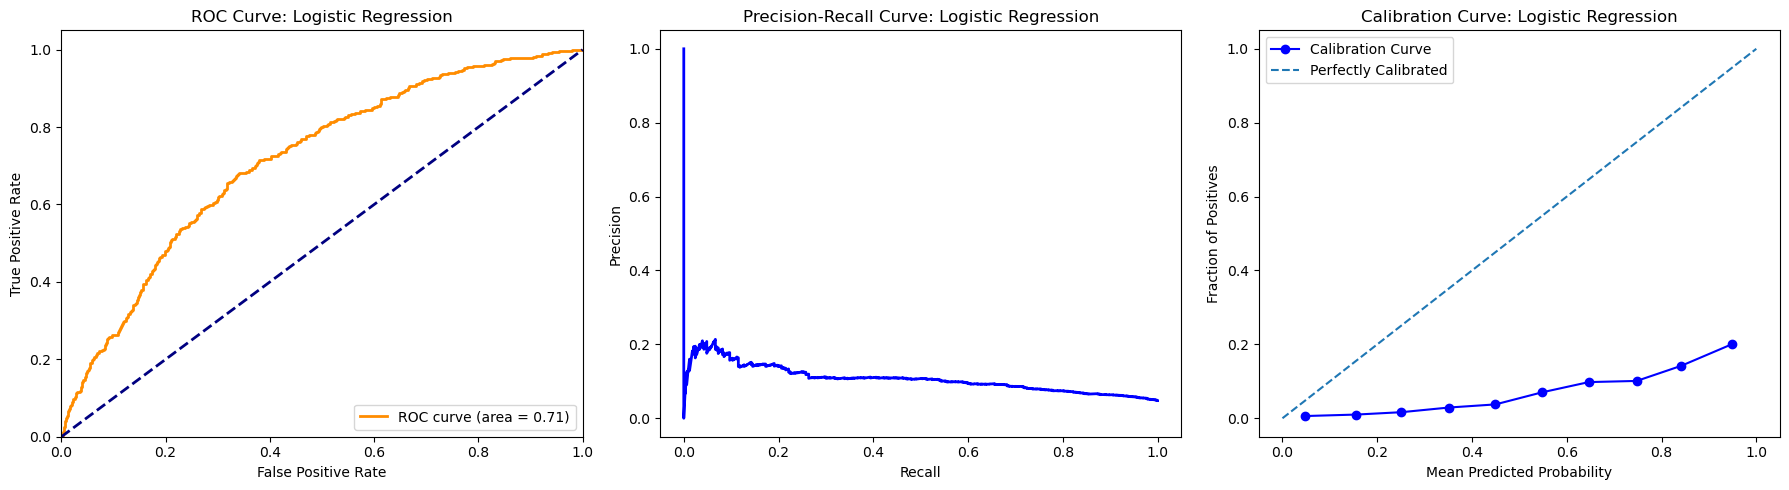

In [21]:
plot_model_performance(y_test, y_pred_proba_lr, model_name="Logistic Regression")

### Random Forest

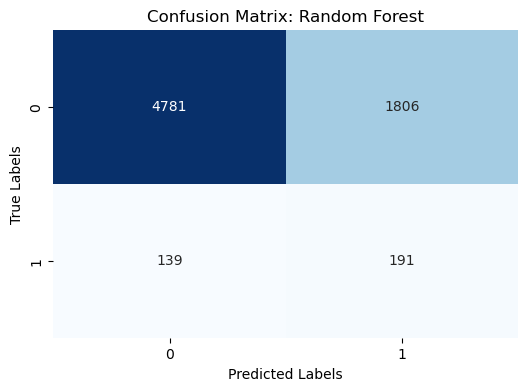

Random Forest Model Performance:
Accuracy: 0.72
ROC-AUC: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      6587
           1       0.10      0.58      0.16       330

    accuracy                           0.72      6917
   macro avg       0.53      0.65      0.50      6917
weighted avg       0.93      0.72      0.80      6917



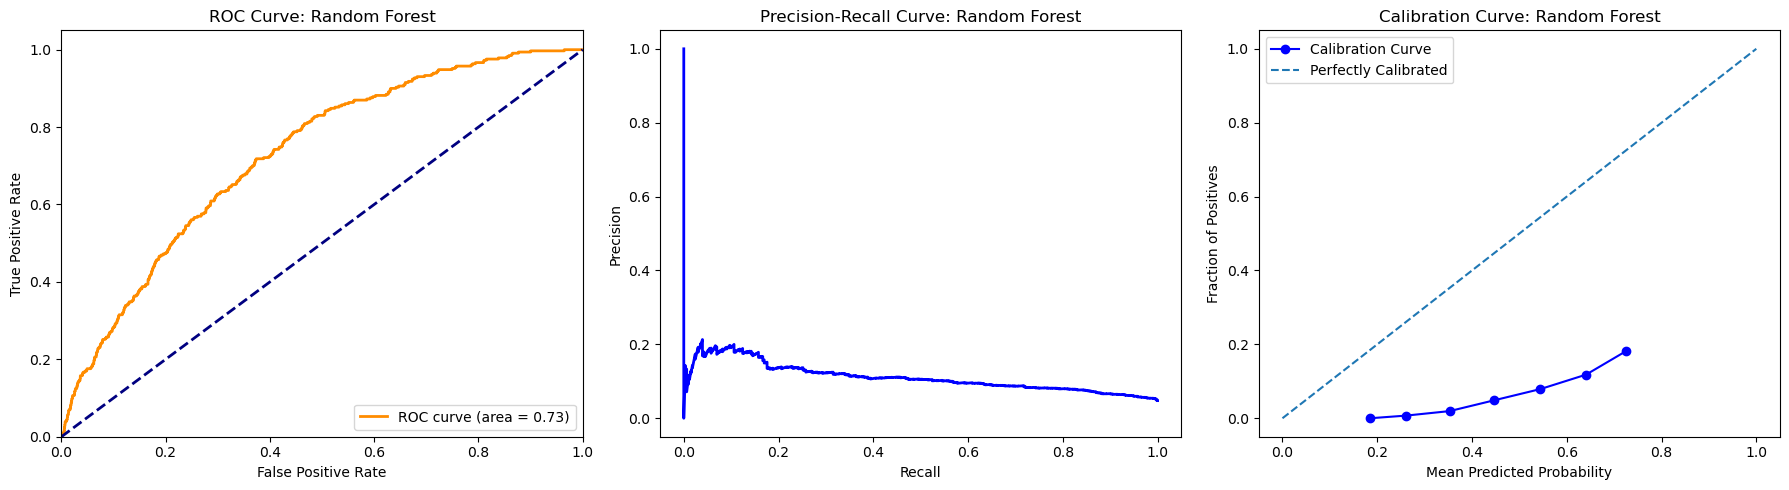

In [54]:
rf_model = RandomForestClassifier(
    class_weight="balanced",
    max_depth=5,  # Set max_depth to control tree depth; adjust as needed
    min_samples_leaf=5,  # Set min_samples_leaf to increase the number of leaf nodes; adjust as needed
    random_state=42  # Set random_state for reproducibility
)

# Fit the model
rf_model.fit(X_train_processed, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_processed)
y_pred_proba_rf = rf_model.predict_proba(X_test_processed)[:, 1]

# Evaluate and plot performance
evaluate_model_performance(y_test, y_pred_rf, y_pred_proba_rf, model_name="Random Forest")
plot_model_performance(y_test, y_pred_proba_rf, model_name="Random Forest")


In [63]:
# Define the parameter grid
param_dist = {
    'n_estimators': [10, 50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'class_weight': [None, 'balanced']         # Weights associated with classes
}

# Initialize the model
rf_model = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=3,        # Number of cross-validation folds
    verbose=2,   # Verbosity level
    random_state=42,
    n_jobs=-1    # Use all available cores
)


In [64]:
# Fit RandomizedSearchCV
random_search.fit(X_train_processed, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)


# Get the best model
best_model = random_search.best_estimator_

# Make predictions
y_pred_rf = best_model.predict(X_test_processed)

# Evaluate performance
print("Test accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Classification report:\n", classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': None, 'bootstrap': True}
Best cross-validation score:  0.9523620222229418
Test accuracy:  0.9521468844874946
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      6587
           1       0.00      0.00      0.00       330

    accuracy                           0.95      6917
   macro avg       0.48      0.50      0.49      6917
weighted avg       0.91      0.95      0.93      6917



### Xgboost

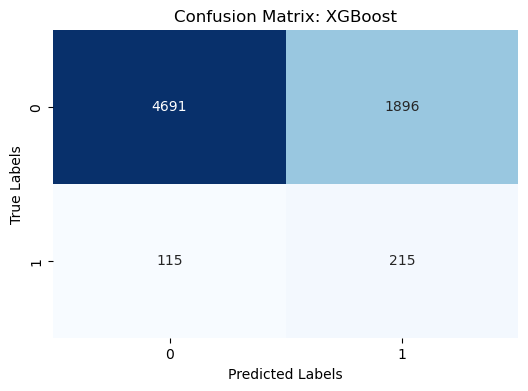

XGBoost Model Performance:
Accuracy: 0.71
ROC-AUC: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      6587
           1       0.10      0.65      0.18       330

    accuracy                           0.71      6917
   macro avg       0.54      0.68      0.50      6917
weighted avg       0.93      0.71      0.79      6917



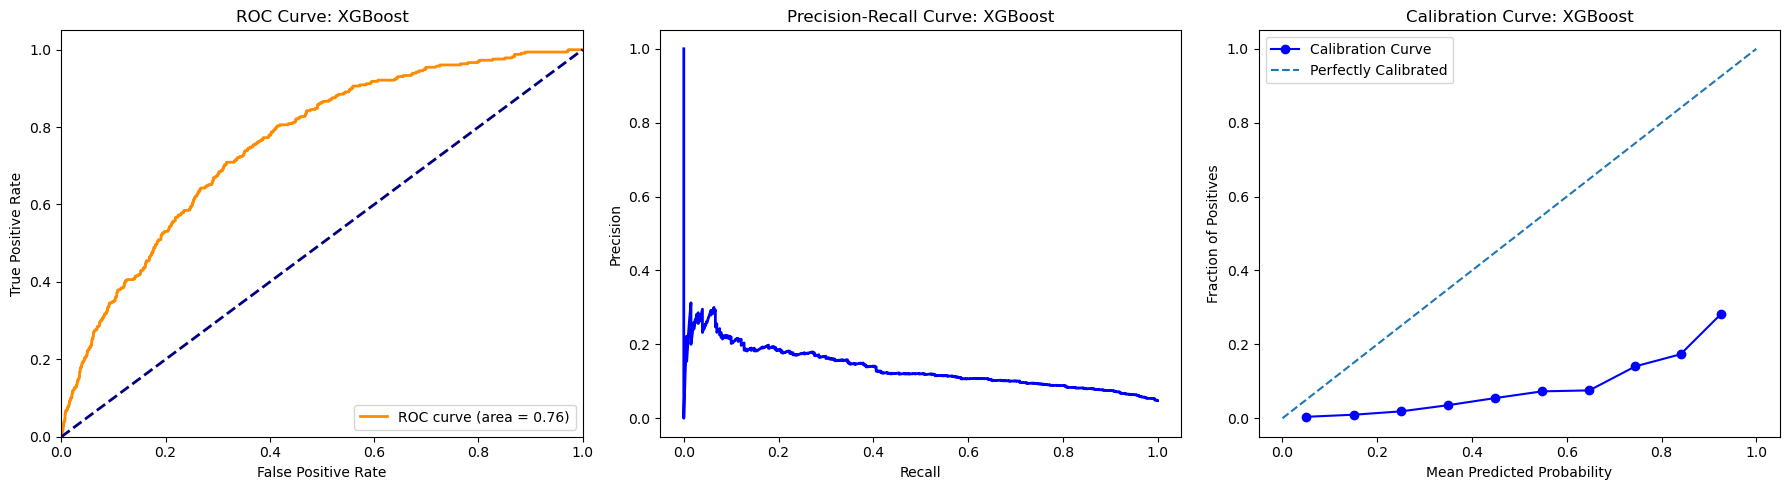

In [38]:
# Pozitif ve negatif sınıf oranlarına göre scale_pos_weight hesapla
pos_class_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_model = XGBClassifier(tree_method='exact', max_depth=2, scale_pos_weight=pos_class_weight)

xgb_model.fit(X_train_processed, y_train)

y_pred_xgb = xgb_model.predict(X_test_processed)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]

evaluate_model_performance(y_test, y_pred_xgb, y_pred_proba_xgb, model_name="XGBoost")
plot_model_performance(y_test, y_pred_proba_xgb, model_name="XGBoost")

### LightGBM

In [23]:
lgb_train_data = lgb.Dataset(X_train_scaled, label=y_train)
lgb_test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=lgb_train_data)

params = {
    'objective': 'binary',       # Binary classification problemi
    'metric': 'binary_logloss',  
    'boosting': 'gbdt',       # Gradient boosting ile modelleme
    'is_unbalance': True,
    'learning_rate': 0.05,
    'num_leaves': 31,       #?  
    'feature_fraction': 0.9,  # Her iterasyonda kullanılacak özellik oranı
    'bagging_fraction': 0.8,  # Her iterasyonda kullanılacak veri oranı
    'bagging_freq': 5,        
    'verbose': -1  
}

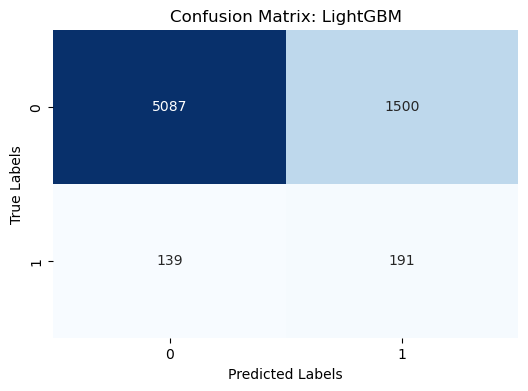

LightGBM Model Performance:
Accuracy: 0.76
ROC-AUC: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      6587
           1       0.11      0.58      0.19       330

    accuracy                           0.76      6917
   macro avg       0.54      0.68      0.53      6917
weighted avg       0.93      0.76      0.83      6917



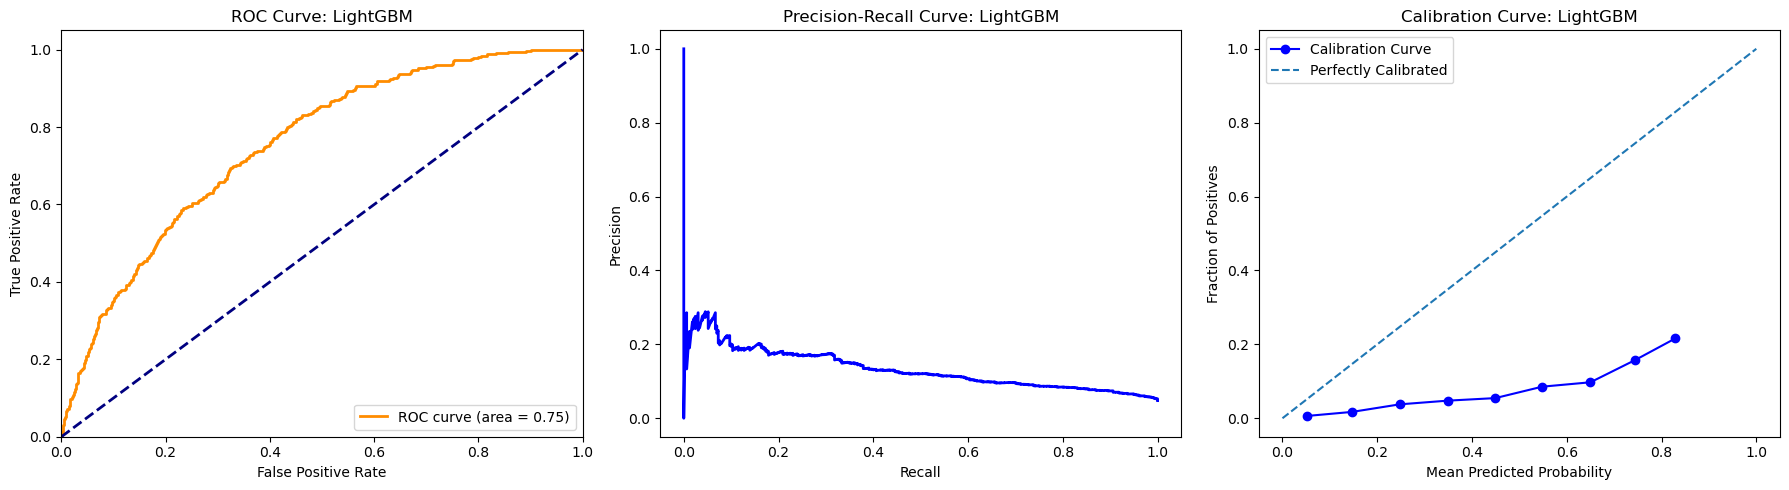

In [24]:
lgb_model = lgb.train(params, lgb_train_data, num_boost_round=100, valid_sets=[lgb_train_data, lgb_test_data])

y_pred_proba_lgb = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)  # Olasılık tahminleri
y_pred_lgb = (y_pred_proba_lgb > 0.5).astype(int)  

evaluate_model_performance(y_test, y_pred_lgb, y_pred_proba_lgb, model_name="LightGBM")
plot_model_performance(y_test, y_pred_proba_lgb, model_name="LightGBM")

### Feature Analysis with LGM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1319, number of negative: 26348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3853
[LightGBM] [Info] Number of data points in the train set: 27667, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047674 -> initscore=-2.994518
[LightGBM] [Info] Start training from score -2.994518


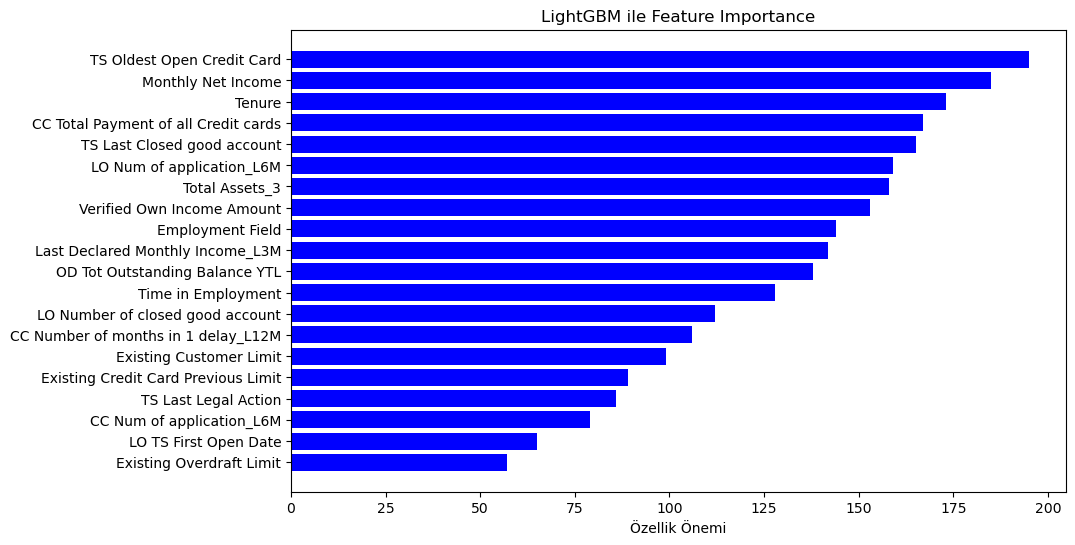

                                        Feature  Importance
5                    TS Oldest Open Credit Card         195
17                           Monthly Net Income         185
19                                       Tenure         173
11         CC Total Payment of all Credit cards         167
7                   TS Last Closed good account         165
3                     LO Num of application_L6M         159
6                                Total Assets_3         158
21                   Verified Own Income Amount         153
18                             Employment Field         144
16             Last Declared Monthly Income_L3M         142
12               OD Tot Outstanding Balance YTL         138
14                           Time in Employment         128
25             LO Number of closed good account         112
15          CC Number of months in 1 delay_L12M         106
10                      Existing Customer Limit          99
2           Existing Credit Card Previou

In [25]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

feature_importances = lgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,  # X_train_scaled kullanılıyor
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# İlk 20 özellik için grafiği çiz
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='b')
plt.xlabel("Özellik Önemi")
plt.title("LightGBM ile Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print(importance_df.head(60))

In [26]:
selected_features = [
    'TS Oldest Open Credit Card',
    'Monthly Net Income',
    'Tenure',
    'CC Total Payment of all Credit cards',
    'TS Last Closed good account',
    'LO Num of application_L6M',
    'Total Assets_3',
    'Verified Own Income Amount',
    'Employment Field',
    'Last Declared Monthly Income_L3M',
    'OD Tot Outstanding Balance YTL',
    'Time in Employment',
    'LO Number of closed good account',
    'CC Number of months in 1 delay_L12M',
    'Existing Customer Limit',
    'Existing Credit Card Previous Limit',
    'TS Last Legal Action',
    'CC Num of application_L6M',
    'LO TS First Open Date',
    'Existing Overdraft Limit',
    'AMC_Transfer_Outstanding',
    'LO Num of open accounts_L12M',
    'Worst Account Status All Credits',
    'CC Worst Payment Status_L24M',
    'Residential Status',
    'CC Num of application_L1M',
    'CC Existing Customers in L6M_Y',
    'Home Phone YN_Y',
    'E Mail Given YN_Y',
    'Last Credit Decision_R',
    'Total Amount of Open Mortgage Loans',
    'Employers Address YN_Y',
    'Guarantee YN_Y',
    'Any Legal Action YN_Y'
]


/Users/bora/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


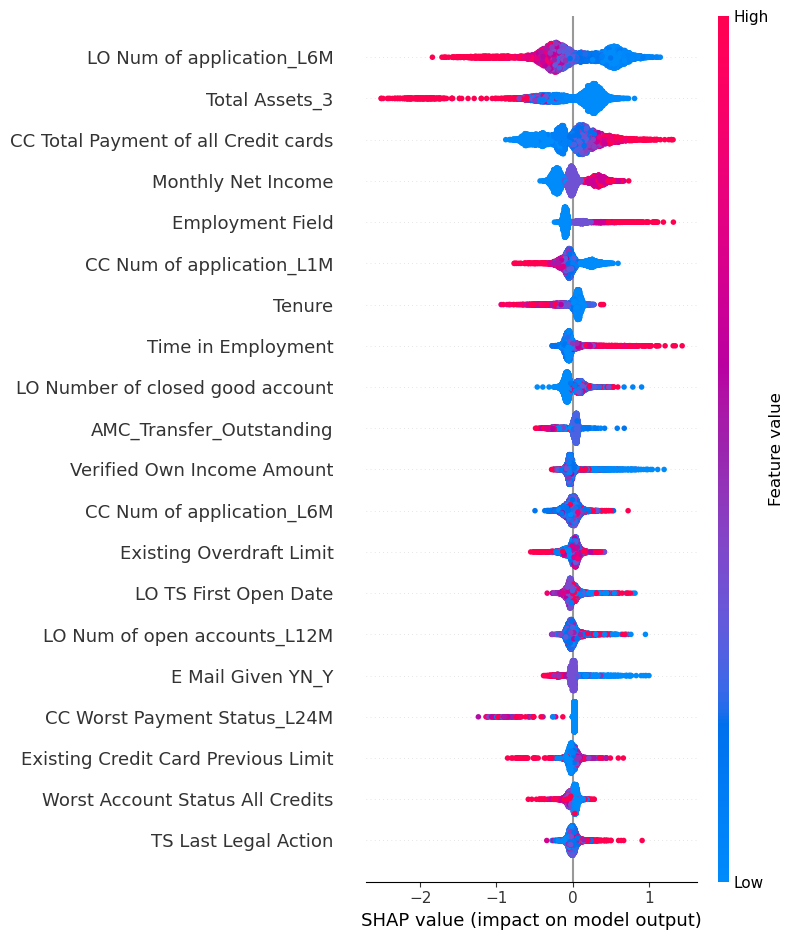

In [44]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=selected_features)